# 5. 서포트 벡터 머신

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

## 5.1 선형 SVM 분류
![선형 서포트 벡터 머신의 예시 이미지](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Svm_max_sep_hyperplane_with_margin.png/556px-Svm_max_sep_hyperplane_with_margin.png)

**선형 서포트 벡터 머신**은 이전의 선형 분류와 같이 선으로 여러 개의 클래스를 분류하는 것이다.
차이점은 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있다는 것이다.
이렇게 찾은 직선은 서로 수평이기 때문에 _두 클래스 사이에서 가장 폭이 넓은 도로를 찾는 것_이라고 생각할 수 있다.

### 5.1.1 소프트 마진 분류
모든 샘플이 도로 바깥쪽에 배치되어 있으면 이를 **하드 마진 분류**라고 한다. 하드 마진 분류에는 두 가지 문제점이 있는데

- 데이터가 선형적으로 구분되어 있어야 작동
- 이상치에 민감

하다는 것이다.

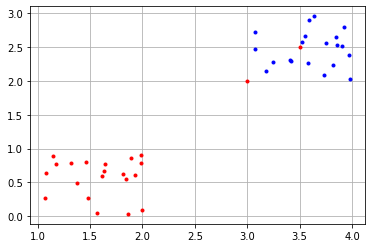

In [2]:
def hard_margin_svm():
    X_a = np.random.rand(20) + 1
    y_a = np.random.rand(20)

    X_b = np.random.rand(20) + 3
    y_b = np.random.rand(20) + 2

    plt.plot(X_a, y_a, "r.")
    plt.plot(X_b, y_b, "b.")
    plt.plot([3, 3.5], [2, 2.5], "r.")
    plt.grid(True)
    plt.show()

hard_margin_svm()

이러한 문제를 피하려면 모델을 유연하게 만들어야 한다. 도로의 폭을 가능한 한 넓게 유지하는 것과 샘플이 도로 중간이나 반대쪽에 있는 것 사이에서 적절한 균형을 잡아야 한다.
이를 **소프트 마진 분류**라고 한다.

In [3]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

> SVM 분류기는 로지스틱 회귀 분류기와 다르게 클래스에 대한 확률을 제공하지 않는다.

## 5.2 비선형 SVM 분류

In [5]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

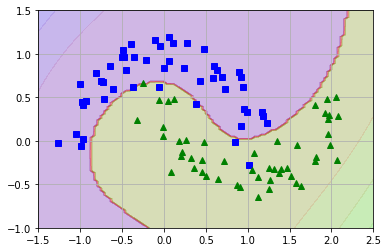

In [6]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.axis([-1.5, 2.5, -1, 1.5])
plt.grid(True)

### 5.2.1 다항식 커널
다항식 특성을 추가하는 것은 간단하고 잘 작동한다. 하지만 낮은 차수의 다항식은 복잡한 데이터셋을 잘 처리하지 못하고,
높은 차수의 다항식은 모델을 느리게 만든다.

다행히도 SVM을 사용할 때는 **커널 트릭**이라는 수학적 기교를 사용할 수 있다.
이를 이용하면 특성을 추가하지 않으면서도 다항식 특성을 추가한 것과 같은 효과를 얻을 수 있다.

In [7]:
from sklearn.svm import SVC

poly_kernal_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernal_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

### 5.2.2 유사도 특성
비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 **랜드마크**와 얼마나 닮았는지 특정하는 **유사도 함수**로 계산한 특성을 추가하는 것이다.
유사도 함수에는 **가우시안 방사 기저 함수** 등이 있다.

$$ \phi_\gamma = \exp(-\gamma \left|| \mathbf{x} - \mathcal{l} \right|| ^2) $$

이 함수의 값은 0(랜드마크에서 아주 멀리 떨어진 경우)부터 1(랜드마크와 같은 위치일 경우)까지 변화하며, 종 모양으로 나타난다.

### 5.2.3 가우시안 RBF 커널
다항 특성 방식과 마찬가지로 유사도 특성 방식도 머신러닝 알고리즘에 유용하게 사용될 수 있다.
추가 특성을 모두 계산하려면 연산 비용이 많이 드는데, 커널 트릭을 이용해서 유사도 특성을 많이 추가한 것과 비슷한 효과를 얻을 수 있다.

In [8]:
rbf_kernal_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

rbf_kernal_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

## 5.3 SVM 회귀
SVM 알고리즘은 회귀에도 사용할 수 있다. 단, SVM을 회귀에 사용하려면 목표가 반대가 되어야 한다.
분류에서 SVM은 두 클래스 간 도로의 폭이 최대가 하는 것이었지만, 회귀에서는 제한된 마진 안에 최대한 많은 샘플이 들어가도록 학습한다.

In [9]:
X = 2 * np.random.rand(50, 1)
y = (4 + 3 * X + np.random.randn(50, 1)).ravel()

In [10]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [11]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

In [12]:
def plot_svm_regression(svm_reg, X, y, axes):
    svm_reg.support_ = find_support_vectors(svm_reg, X, y)
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.grid(True)
    plt.axis(axes)

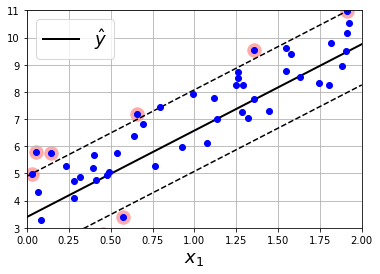

In [13]:
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])

In [14]:
svm_reg_log_ep = LinearSVR(epsilon=0.5, random_state=42)
svm_reg_log_ep.fit(X, y)

LinearSVR(epsilon=0.5, random_state=42)

In [15]:
svm_reg_log_ep.support_ = find_support_vectors(svm_reg_log_ep, X, y)

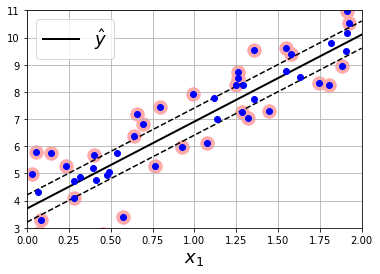

In [16]:
plot_svm_regression(svm_reg_log_ep, X, y, [0, 2, 3, 11])

마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다. 이를 **$\epsilon$에 민감하지 않다**고 한다.

In [17]:
X = 2 * np.random.rand(100, 1) - 1
y = (0.2 + 0.1 * X + X ** 2 + np.random.randn(100, 1) / 10).ravel()

In [18]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')